In [2]:
import sys
import time
import torch
import matplotlib.pyplot as plt

sys.path.append('../..')
from fast_nystrom_attention import sample_landmarks

In [3]:
# Time sampling landmarks with different sequence lengths using both FPS and random sampling
def time_sampling(seq_len, num_samples, hidden_size=4096//32, sample_method='fps', device='cpu', dtype=torch.float32, fps_backend='torchfps'):
    x = torch.rand(2, seq_len, hidden_size, dtype=dtype, device=device)
    start_time = time.time()
    
    _ = sample_landmarks(
        x, 
        num_samples, 
        sample_method=sample_method,
        fps_backend=fps_backend,
    )
    
    elapsed_time = time.time() - start_time
    return elapsed_time

# Define sequence lengths and number of samples
sequence_lengths = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000]
num_samples = 256

def run_timing_for_dtype(dtype, device='cpu'):
    fps_torchfps_times = []
    fps_torch3d_times = []
    random_times = []
    for seq_len in sequence_lengths:
        elapsed_time = time_sampling(seq_len, num_samples, sample_method='fps', device=device, dtype=dtype, fps_backend='torchfps')
        fps_torchfps_times.append(elapsed_time)
        print(f"FPS (torchfps) {dtype} for seq_len={seq_len}: {elapsed_time:.4f} seconds")
    
    for seq_len in sequence_lengths:
        elapsed_time = time_sampling(seq_len, num_samples, sample_method='fps', device=device, dtype=dtype, fps_backend='torch3d')
        fps_torch3d_times.append(elapsed_time)
        print(f"FPS (torch3d) {dtype} for seq_len={seq_len}: {elapsed_time:.4f} seconds")
    
    for seq_len in sequence_lengths:
        elapsed_time = time_sampling(seq_len, num_samples, sample_method='random', device=device, dtype=dtype)
        random_times.append(elapsed_time)
        print(f"Random sampling {dtype} for seq_len={seq_len}: {elapsed_time:.4f} seconds")
    
    return fps_torchfps_times, fps_torch3d_times, random_times

# Run timing for fp32 on CPU
fps_torchfps_fp32_times, fps_torch3d_fp32_times, random_fp32_times = run_timing_for_dtype(torch.float32, device='cpu')

# Run timing for fp16 on CPU
fps_torchfps_fp16_times, fps_torch3d_fp16_times, random_fp16_times = run_timing_for_dtype(torch.float16, device='cpu')

# Run timing for fp32 on GPU (if available)
fps_torchfps_fp32_gpu_times = []
fps_torch3d_fp32_gpu_times = []
random_fp32_gpu_times = []
fps_torchfps_fp16_gpu_times = []
fps_torch3d_fp16_gpu_times = []
random_fp16_gpu_times = []
if torch.cuda.is_available():
    device = torch.device('cuda:0') #torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda:0')
    fps_torchfps_fp32_gpu_times, fps_torch3d_fp32_gpu_times, random_fp32_gpu_times = run_timing_for_dtype(torch.float32, device=device)
    fps_torchfps_fp16_gpu_times, fps_torch3d_fp16_gpu_times, random_fp16_gpu_times = run_timing_for_dtype(torch.float16, device=device)
else:
    print("CUDA not available; skipping GPU timings.")

FPS (torchfps) torch.float32 for seq_len=400: 0.0332 seconds
FPS (torchfps) torch.float32 for seq_len=800: 0.0231 seconds
FPS (torchfps) torch.float32 for seq_len=1200: 0.0347 seconds
FPS (torchfps) torch.float32 for seq_len=1600: 0.0462 seconds
FPS (torchfps) torch.float32 for seq_len=2000: 0.0590 seconds
FPS (torchfps) torch.float32 for seq_len=2400: 0.0707 seconds
FPS (torchfps) torch.float32 for seq_len=2800: 0.0813 seconds
FPS (torchfps) torch.float32 for seq_len=3200: 0.0941 seconds
FPS (torchfps) torch.float32 for seq_len=2400: 0.0707 seconds
FPS (torchfps) torch.float32 for seq_len=2800: 0.0813 seconds
FPS (torchfps) torch.float32 for seq_len=3200: 0.0941 seconds
FPS (torchfps) torch.float32 for seq_len=3600: 0.1083 seconds
FPS (torchfps) torch.float32 for seq_len=4000: 0.1189 seconds
FPS (torch3d) torch.float32 for seq_len=400: 0.0128 seconds
FPS (torch3d) torch.float32 for seq_len=800: 0.0267 seconds
FPS (torchfps) torch.float32 for seq_len=3600: 0.1083 seconds
FPS (torchfps)

In [4]:
# Compare FPS methods: sample_landmarks (torch3d) vs sample_landmarks (torchfps)
def compare_fps_methods(seq_len, num_samples, device='cpu'):
    points = torch.rand(2, seq_len, 3, dtype=torch.float32, device=device)
    mask = torch.ones(2, seq_len, dtype=torch.bool, device=device)
    
    indices_torch3d = sample_landmarks(points, num_samples, sample_method='fps', fps_backend='torch3d', guarantee_mask=mask)
    indices_torchfps = sample_landmarks(points, num_samples, sample_method='fps', fps_backend='torchfps', guarantee_mask=mask)
    
    sorted_torch3d = torch.sort(indices_torch3d, dim=1).values
    sorted_torchfps = torch.sort(indices_torchfps, dim=1).values
    same = torch.eq(sorted_torch3d, sorted_torchfps).all(dim=1)
    
    overlap_counts = (indices_torch3d[:, :, None] == indices_torchfps[:, None, :]).any(dim=2).sum(dim=1)
    overlap_ratio = overlap_counts.float() / num_samples
    return same, overlap_ratio

# Run check for a representative sequence length
check_seq_len = sequence_lengths[len(sequence_lengths) // 2]
same_mask, overlap_ratio = compare_fps_methods(check_seq_len, num_samples)
print(f"FPS index sets identical per batch: {same_mask.tolist()}")
print(f"FPS overlap ratio per batch: {overlap_ratio.tolist()}")

FPS index sets identical per batch: [True, True]
FPS overlap ratio per batch: [1.0, 1.0]


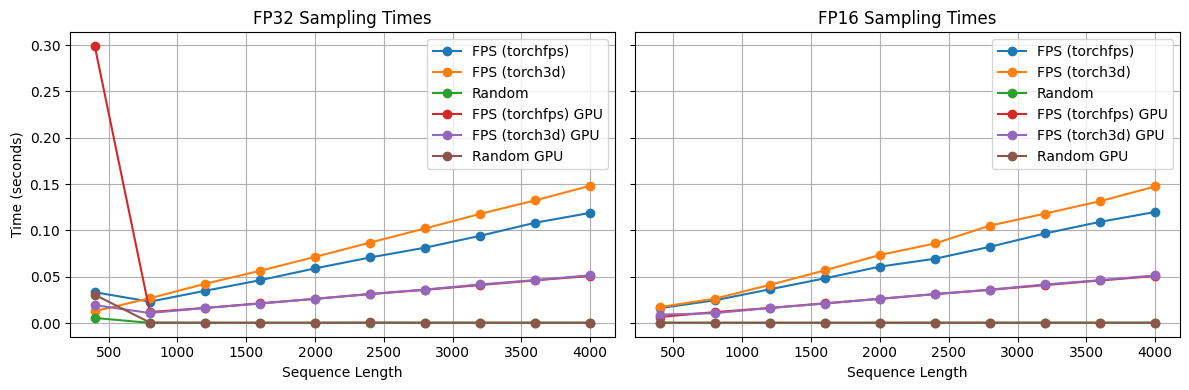

In [5]:
# Graph the results
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# FP32
axes[0].plot(sequence_lengths, fps_torchfps_fp32_times, label='FPS (torchfps)', marker='o')
axes[0].plot(sequence_lengths, fps_torch3d_fp32_times, label='FPS (torch3d)', marker='o')
axes[0].plot(sequence_lengths, random_fp32_times, label='Random', marker='o')
if fps_torchfps_fp32_gpu_times:
    axes[0].plot(sequence_lengths, fps_torchfps_fp32_gpu_times, label='FPS (torchfps) GPU', marker='o')
if fps_torch3d_fp32_gpu_times:
    axes[0].plot(sequence_lengths, fps_torch3d_fp32_gpu_times, label='FPS (torch3d) GPU', marker='o')
if random_fp32_gpu_times:
    axes[0].plot(sequence_lengths, random_fp32_gpu_times, label='Random GPU', marker='o')
axes[0].set_title('FP32 Sampling Times')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Time (seconds)')
axes[0].grid(True)
axes[0].legend()

# FP16
axes[1].plot(sequence_lengths, fps_torchfps_fp16_times, label='FPS (torchfps)', marker='o')
axes[1].plot(sequence_lengths, fps_torch3d_fp16_times, label='FPS (torch3d)', marker='o')
axes[1].plot(sequence_lengths, random_fp16_times, label='Random', marker='o')
if fps_torchfps_fp16_gpu_times:
    axes[1].plot(sequence_lengths, fps_torchfps_fp16_gpu_times, label='FPS (torchfps) GPU', marker='o')
if fps_torch3d_fp16_gpu_times:
    axes[1].plot(sequence_lengths, fps_torch3d_fp16_gpu_times, label='FPS (torch3d) GPU', marker='o')
if random_fp16_gpu_times:
    axes[1].plot(sequence_lengths, random_fp16_gpu_times, label='Random GPU', marker='o')
axes[1].set_title('FP16 Sampling Times')
axes[1].set_xlabel('Sequence Length')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

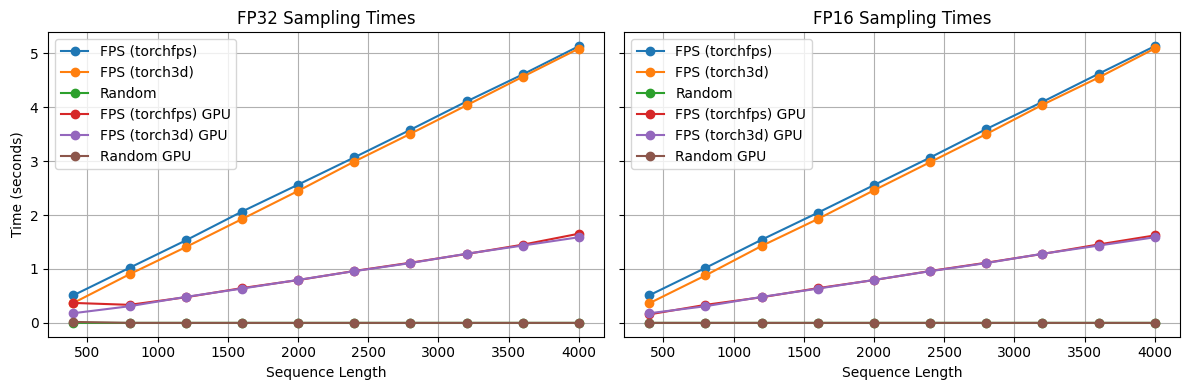

In [4]:
# Graph the results
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# FP32
axes[0].plot(sequence_lengths, fps_torchfps_fp32_times, label='FPS (torchfps)', marker='o')
axes[0].plot(sequence_lengths, fps_torch3d_fp32_times, label='FPS (torch3d)', marker='o')
axes[0].plot(sequence_lengths, random_fp32_times, label='Random', marker='o')
if fps_torchfps_fp32_gpu_times:
    axes[0].plot(sequence_lengths, fps_torchfps_fp32_gpu_times, label='FPS (torchfps) GPU', marker='o')
if fps_torch3d_fp32_gpu_times:
    axes[0].plot(sequence_lengths, fps_torch3d_fp32_gpu_times, label='FPS (torch3d) GPU', marker='o')
if random_fp32_gpu_times:
    axes[0].plot(sequence_lengths, random_fp32_gpu_times, label='Random GPU', marker='o')
axes[0].set_title('FP32 Sampling Times')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Time (seconds)')
axes[0].grid(True)
axes[0].legend()

# FP16
axes[1].plot(sequence_lengths, fps_torchfps_fp16_times, label='FPS (torchfps)', marker='o')
axes[1].plot(sequence_lengths, fps_torch3d_fp16_times, label='FPS (torch3d)', marker='o')
axes[1].plot(sequence_lengths, random_fp16_times, label='Random', marker='o')
if fps_torchfps_fp16_gpu_times:
    axes[1].plot(sequence_lengths, fps_torchfps_fp16_gpu_times, label='FPS (torchfps) GPU', marker='o')
if fps_torch3d_fp16_gpu_times:
    axes[1].plot(sequence_lengths, fps_torch3d_fp16_gpu_times, label='FPS (torch3d) GPU', marker='o')
if random_fp16_gpu_times:
    axes[1].plot(sequence_lengths, random_fp16_gpu_times, label='Random GPU', marker='o')
axes[1].set_title('FP16 Sampling Times')
axes[1].set_xlabel('Sequence Length')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()